In [1]:
import requests
import json
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import itertools
from itertools import product
import random


In [2]:
df = pd.read_csv('../data/spotify_dataset.csv', usecols=range(4), lineterminator='\n', header=0)

In [3]:
df.columns = [x.replace('"', '').lstrip() for x in df.columns]

In [4]:
playlists = df['playlistname'].unique()
print('Number of Playlists:', len(playlists))
print('Number of Artists:', len(df['artistname'].unique()))

Number of Playlists: 161530
Number of Artists: 290002


#### Problem:
- Networkx takes too much time to load up a graph with all the data <br>
- In ~5 min we can retrieve 2000 artist genres


#### Potential Solution:
- Sample 1,000 playlists
- See if there is a sufficient amount of artists and playlist appearances

In [5]:
sample_playlists = np.random.choice(playlists, 5000, replace=False)
sampled_df = df[df['playlistname'].isin(sample_playlists)]

In [6]:
print('Number of songs in sample:', len(sampled_df))
print('Number of Artists:', len(sampled_df['artistname'].unique()))

Number of songs in sample: 349600
Number of Artists: 33479


In [7]:
appearances = sampled_df.groupby('artistname').agg({'trackname':'count', 'playlistname':lambda x: len(x.unique())})
appearances.sort_values(by=['trackname', 'playlistname'])

,trackname,playlistname
artistname,,
#1 Dubstep Masters,1,1
#That Power,1,1
(+44),1,1
(Lehar),1,1
*NSYNC,1,1
...,...,...
David Bowie,944,124
Eminem,976,134
Dave Matthews Band,1276,33


- There are some artists that appear on an insignificant amount of playlists, define this to be anything less than 10

In [8]:
artists = appearances[appearances['playlistname']>=10].index
print('# of artists on >= 10 playlists (sample):', len(artists))

# of artists on >= 10 playlists (sample): 2037


In [9]:
df1 = sampled_df[sampled_df['artistname'].isin(artists)]
df1

,user_id,artistname,trackname,playlistname
17374,29320fd2d36575b40d21b623adcf12b2,Jens Lekman,A Postcard to Nina,My heart is in the TV tower in Berlin
17375,29320fd2d36575b40d21b623adcf12b2,Still Corners,Berlin Lovers,My heart is in the TV tower in Berlin
17376,29320fd2d36575b40d21b623adcf12b2,Haim,Don't Save Me,My heart is in the TV tower in Berlin
17377,29320fd2d36575b40d21b623adcf12b2,Twin Shadow,Five Seconds,My heart is in the TV tower in Berlin
17379,29320fd2d36575b40d21b623adcf12b2,Orchestral Manoeuvres In The Dark,Helen of Troy,My heart is in the TV tower in Berlin
...,...,...,...,...
12900123,8d27d5741b3210e41ab3a499c1141af9,MGMT,Time to Pretend,Powerfully Music
12900124,8d27d5741b3210e41ab3a499c1141af9,Manu Chao,Tristeza Maleza,Powerfully Music
12900125,8d27d5741b3210e41ab3a499c1141af9,Rihanna,We Found Love,Powerfully Music
12900126,8d27d5741b3210e41ab3a499c1141af9,Two Door Cinema Club,What You Know,Powerfully Music


- Only take playlists that have more than 1 artist (otherwise there's no edge)

In [10]:
df1_grped = df1.groupby('playlistname').agg({'artistname':lambda x: len(x.unique())})
playlists = df1_grped[df1_grped['artistname'] > 1].index

In [13]:
df2 = df1[df1['playlistname'].isin(playlists)]
df

,user_id,artistname,trackname,playlistname
0,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,(The Angels Wanna Wear My) Red Shoes,HARD ROCK 2010
1,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,"(What's So Funny 'Bout) Peace, Love And Unders...",HARD ROCK 2010
2,9cc0cfd4d7d7885102480dd99e7a90d6,Tiffany Page,7 Years Too Late,HARD ROCK 2010
3,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,Accidents Will Happen,HARD ROCK 2010
4,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,Alison,HARD ROCK 2010
...,...,...,...,...
12901974,2302bf9c64dc63d88a750215ed187f2c,Mötley Crüe,Wild Side,iPhone
12901975,2302bf9c64dc63d88a750215ed187f2c,John Lennon,Woman,iPhone
12901976,2302bf9c64dc63d88a750215ed187f2c,Tom Petty,You Don't Know How It Feels,iPhone
12901977,2302bf9c64dc63d88a750215ed187f2c,Tom Petty,You Wreck Me,iPhone


In [14]:
# same def as quarter 1
def read_edge(gph, n0, n1):
    if gph.has_edge(n0, n1):
        gph[n0][n1]['weight'] +=1
        return gph[n0][n1]['weight']
    else:
        gph.add_edge(n0, n1, weight=1)
        return 1

In [15]:
%%time
G = nx.Graph()
# if not unique, could weight the number of times the artist appears in that playlist
df2_grp = df2.groupby('playlistname').agg({'artistname': lambda x: (x).unique()})

for i in range(len(df2_grp)):
    
    for a in (df2_grp.iloc[i]):
        for a1, a2 in itertools.combinations(a, 2):
            read_edge(G, a1, a2)


CPU times: user 7.11 s, sys: 262 ms, total: 7.37 s
Wall time: 7.47 s


In [16]:
# threshold = 1
# long_edges = list(filter(lambda e: e[2] <= threshold, (e for e in G.edges.data('weight'))))
# G.remove_edges_from(long_edges)

CPU times: user 56.2 s, sys: 1.61 s, total: 57.8 s
Wall time: 58.6 s


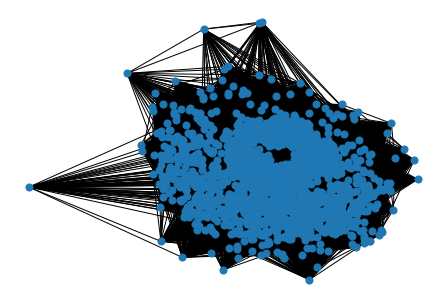

In [17]:
%%time
nx.draw(G, node_size=50)


In [18]:
G.size()

1146745

In [19]:
weight_dict = {}
node_weights = nx.get_edge_attributes(G, "weight")
for i in node_weights:
    if 'Vampire Weekend' in i:
        weight_dict[i] = node_weights[i]

In [20]:
sorted(weight_dict.items(), key=lambda x:x[1], reverse=True)

[(('Daft Punk', 'Vampire Weekend'), 40),
 (('MGMT', 'Vampire Weekend'), 34),
 (('The Strokes', 'Vampire Weekend'), 34),
 (('Vampire Weekend', 'Phoenix'), 33),
 (('Arctic Monkeys', 'Vampire Weekend'), 32),
 (('The Killers', 'Vampire Weekend'), 32),
 (('Coldplay', 'Vampire Weekend'), 31),
 (('Arcade Fire', 'Vampire Weekend'), 30),
 (('The Black Keys', 'Vampire Weekend'), 29),
 (('Yeah Yeah Yeahs', 'Vampire Weekend'), 29),
 (('Kings Of Leon', 'Vampire Weekend'), 27),
 (('Two Door Cinema Club', 'Vampire Weekend'), 27),
 (('LCD Soundsystem', 'Vampire Weekend'), 27),
 (('Florence + The Machine', 'Vampire Weekend'), 26),
 (('Passion Pit', 'Vampire Weekend'), 25),
 (('Radiohead', 'Vampire Weekend'), 25),
 (('Franz Ferdinand', 'Vampire Weekend'), 25),
 (('The xx', 'Vampire Weekend'), 24),
 (('The Rolling Stones', 'Vampire Weekend'), 24),
 (('Foster The People', 'Vampire Weekend'), 24),
 (('Mumford & Sons', 'Vampire Weekend'), 24),
 (('Muse', 'Vampire Weekend'), 24),
 (('The Kooks', 'Vampire Wee

In [21]:
len(G.nodes)

2037

In [22]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

def get_artist_genres(artist_names):
    client_id = '8ac5bd4f29854a4abb37648a5b7833d8'
    client_secret = 'c9f1281a0f774d97ae7d002139e53049'
    client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

    artist_dict = {}
    
    for artist in artists:
        result = sp.search(artist, type='artist')['artists']['items']
        if len(result) > 0:
            artist_dict[artist] = result[0]['genres']
    return artist_dict


In [23]:
%%time
genres = get_artist_genres(list(G.nodes))

CPU times: user 5.08 s, sys: 938 ms, total: 6.02 s
Wall time: 4min 28s


In [24]:
genres

{'!!!': ['alternative dance',
  'dance rock',
  'dance-punk',
  'electroclash',
  'electronica',
  'modern rock',
  'new rave',
  'sacramento indie'],
 '10cc': ['album rock',
  'art rock',
  'blues rock',
  'classic rock',
  'classic uk pop',
  'folk rock',
  'glam rock',
  'mellow gold',
  'rock',
  'soft rock',
  'symphonic rock',
  'yacht rock'],
 '112': ['atl hip hop',
  'boy band',
  'contemporary r&b',
  'dance pop',
  'gangster rap',
  'hip pop',
  'pop rap',
  'r&b',
  'southern hip hop',
  'urban contemporary'],
 '2 Chainz': ['atl hip hop',
  'gangster rap',
  'hip hop',
  'pop rap',
  'rap',
  'southern hip hop',
  'trap'],
 '2Pac': ['g funk', 'gangster rap', 'hip hop', 'rap', 'west coast rap'],
 '3 Doors Down': ['alternative metal', 'nu metal', 'pop rock', 'post-grunge'],
 '311': ['alternative metal',
  'alternative rock',
  'funk metal',
  'funk rock',
  'nu metal',
  'pop rock',
  'rap rock',
  'reggae fusion',
  'rock'],
 '3OH!3': ['dance pop',
  'electropowerpop',
  'mod

In [33]:
def filter_dataset(df):
    appearances = df.groupby('artistname').agg({'trackname':'count', 'playlistname':lambda x: len(x.unique())})
    # why are we printing this?
    # print(appearances.sort_values(by=['trackname', 'playlistname']))

    artists = appearances[appearances['playlistname']>=10].index
     # or this?
    # print('# of artists on >= 10 playlists (sample):', len(artists))

    df1 = df[df['artistname'].isin(artists)]

    df1_grped = df1.groupby('playlistname').agg({'artistname':lambda x: len(x.unique())})
    playlists = df1_grped[df1_grped['artistname'] > 1].index
    df2 = df1[df1['playlistname'].isin(playlists)]
    print("dataframe filtered")
    return df2

In [25]:
%%time
genres = get_artist_genres(list(G.nodes)[0:200])

CPU times: user 5.23 s, sys: 1.04 s, total: 6.27 s
Wall time: 4min 30s
